In [1]:
#import standard things
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set() # use seaborn plotting style

#import file/os things
from pathlib import Path
import pickle
import codecs

#import for preprocessing stuff
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#import for models selection and train test split
from sklearn.model_selection import train_test_split
from sklearn import svm

#import for making the pipeline
from sklearn.pipeline import make_pipeline

#import for getting stats and stuff
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#Setup data directory variable for global use
data_dir = Path.home() / "Desktop" / "bah-intermediate" / "CAPSTONE" / "data"
test_data = Path.home() / "Desktop" / "bah-intermediate" / "CAPSTONE" / "test_data"

In [2]:
def svm_pipeline(text_list, target_array, topic_list):
    #create stop_words list
    stop_words = stopwords.words('english')
    
    model = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), stop_words=stop_words), 
                          svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))

    train_data, test_data, train_targets, test_targets = train_test_split(text_list, 
                                                                          target_array,
                                                                          test_size=0.3,
                                                                          random_state=42)

    print("We have {} unique classes".format(len(topic_list)))
    print("We have {} training samples".format(len(train_data)))
    print("We have {} test samples".format(len(test_data)))

    # Train the model using the training data
    model.fit(train_data, train_targets)

    # Predict the categories of the test data
    predicted_categories = model.predict(test_data)

    # plot the confusion matrix
    mat = confusion_matrix(test_targets, predicted_categories)

    sns.heatmap(mat.T, square = True, annot=True, fmt = "d", 
                xticklabels=['business', 'sport', 'politics', 'tech', 'entertainment'],
                yticklabels=['business', 'sport', 'politics', 'tech', 'entertainment'])

    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()

    print("The accuracy is {}".format(accuracy_score(test_targets, predicted_categories)))
    return model

In [3]:
def make_prediction(text, model, df):
    topics = df.topic.unique()
    prediction = model.predict([text])
    print(prediction-1)
    return topics[prediction-1]

In [4]:
df = pickle.load(open(data_dir / 'bbc_df_trimmed.pickle', 'rb'))

df['target'] = df.topic.map({'business':1, 'sport':2, 'politics':3, 'tech':4, 'entertainment':5})

df.head()

,text,title,topic,tokens,stemmed_list,stemmed,lemmed_list,lemmed,word_count,target
0,Ad sales boost Time Warner profit\n\nQuarterly...,Ad sales boost Time Warner profit,business,"[ad, sales, boost, time, warner, profit, quart...","[sale, boost, time, warner, profit, quarterli,...",sale boost time warner profit quarterli profit...,"[sale, boost, time, warner, profit, quarterly,...",sale boost time warner profit quarterly profit...,221,1
1,Dollar gains on Greenspan speech\n\nThe dollar...,Dollar gains on Greenspan speech,business,"[dollar, gains, on, greenspan, speech, the, do...","[dollar, gain, greenspan, speech, dollar, hit,...",dollar gain greenspan speech dollar hit highes...,"[dollar, gain, greenspan, speech, dollar, hit,...",dollar gain greenspan speech dollar hit high l...,212,1
2,Yukos unit buyer faces loan claim\n\nThe owner...,Yukos unit buyer faces loan claim,business,"[yukos, unit, buyer, faces, loan, claim, the, ...","[yuko, unit, buyer, face, loan, claim, owner, ...",yuko unit buyer face loan claim owner embattl ...,"[yukos, unit, buyer, face, loan, claim, owner,...",yukos unit buyer face loan claim owner embattl...,149,1
3,High fuel prices hit BA's profits\n\nBritish A...,High fuel prices hit BA's profits,business,"[high, fuel, prices, hit, ba, 's, profits, bri...","[high, fuel, price, hit, profit, british, airw...",high fuel price hit profit british airway blam...,"[high, fuel, price, hit, profit, british, airw...",high fuel price hit profit british airway blam...,216,1
4,Pernod takeover talk lifts Domecq\n\nShares in...,Pernod takeover talk lifts Domecq,business,"[pernod, takeover, talk, lifts, domecq, shares...","[pernod, takeov, talk, lift, domecq, share, dr...",pernod takeov talk lift domecq share drink foo...,"[pernod, takeover, talk, lift, domecq, share, ...",pernod takeover talk lift domecq share drink f...,152,1


# Prediction Stuff

We have 5 unique classes
We have 1540 training samples
We have 660 test samples


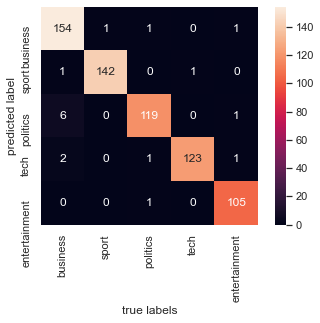

The accuracy is 0.9742424242424242


In [5]:
svm_model_piped = svm_pipeline(df.text.to_list(), df.target.to_numpy(), df.topic.unique())

In [10]:
with codecs.open(test_data / 'test_article1.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read()

print("Prediction: ", 
      make_prediction(text, svm_model_piped, df),
      "\nActual topic: Politics")

[2]
Prediction:  ['politics'] 
Actual topic: Politics


In [8]:
my_text = 'drugs'
print(make_prediction(my_text, svm_model_piped, df))

[1]
['entertainment']


In [9]:
my_text2 = 'sex drugs rock and roll'
print(make_prediction(my_text2, svm_model_piped, df))

[4]
['tech']


# All the Tfidf and svm.SVC steps below

In [ ]:
train_data, test_data, train_targets, test_targets = train_test_split(df.lemmed, 
                                                                      df.topic, 
                                                                      test_size=0.3, 
                                                                      random_state=42)
encoder = LabelEncoder()
train_targets = encoder.fit_transform(train_targets)
test_targets = encoder.fit_transform(test_targets)

tfidf_vect = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
tfidf_vect.fit(df.lemmed)

train_data_tfidf = tfidf_vect.transform(train_data)
test_data_tfidf = tfidf_vect.transform(test_data)

print(tfidf_vect.vocabulary_)

print(train_data_tfidf)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
svm_model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm_model.fit(train_data_tfidf,train_targets)

# predict the labels on validation dataset
predictions_svm = svm_model.predict(test_data_tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_svm, test_targets)*100)

# plot the confusion matrix
mat = confusion_matrix(test_targets, predictions_svm)

sns.heatmap(mat.T, square = True, annot=True, fmt = "d", 
            xticklabels=['business', 'sport', 'politics', 'tech', 'entertainment'],
            yticklabels=['business', 'sport', 'politics', 'tech', 'entertainment'])

plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

In [ ]:
svm_model_piped.steps[0]

In [ ]:
svm_model.named_steps['tfidfvectorizer'].get_feature_names()